In [1]:
from Dataset.dataset import Eve, Bars3D, Points3D
import numpy as np
import pandas as pd

from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis

from lifelines import CoxPHFitter
import pickle
from model import XSurvKMeansRF
import time
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

C:\Users\Abd\AppData\Local\conda\conda\envs\hh\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import imp
imp.find_module("matplotlib")

(None,
 'C:\\Users\\Abd\\AppData\\Local\\conda\\conda\\envs\\hh\\lib\\site-packages\\matplotlib',
 ('', '', 5))

Dataset Description =======================
Dataset Name: Points3D
Dataset Shape: (9000, 5)
Events: 30.18 %
NaN Values: 0.00 %
Events % in splits: 30.17, 30.17, 30.17, 30.22, 30.17, 



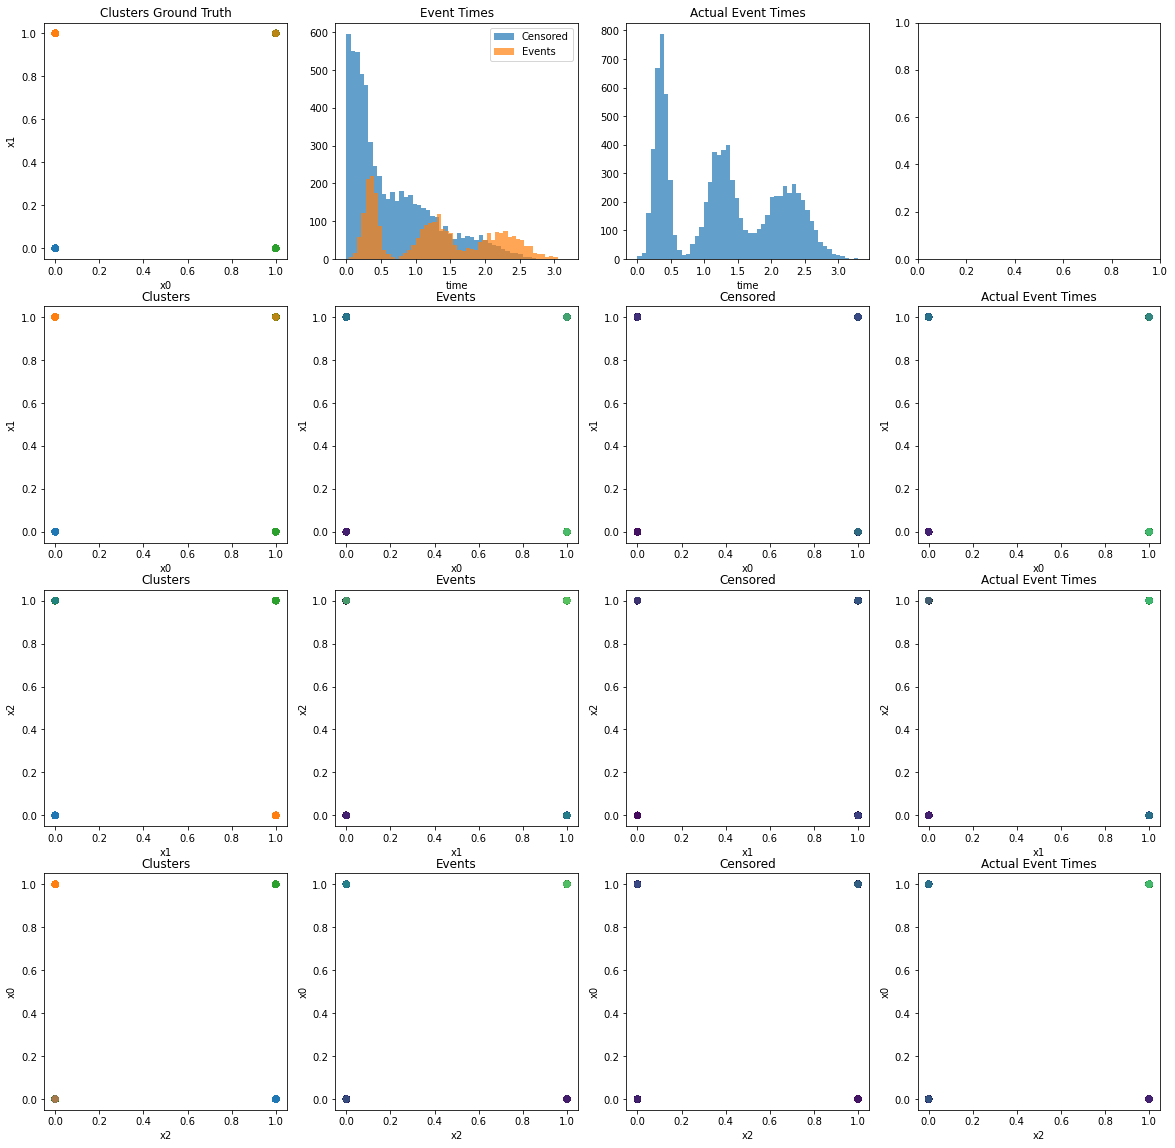

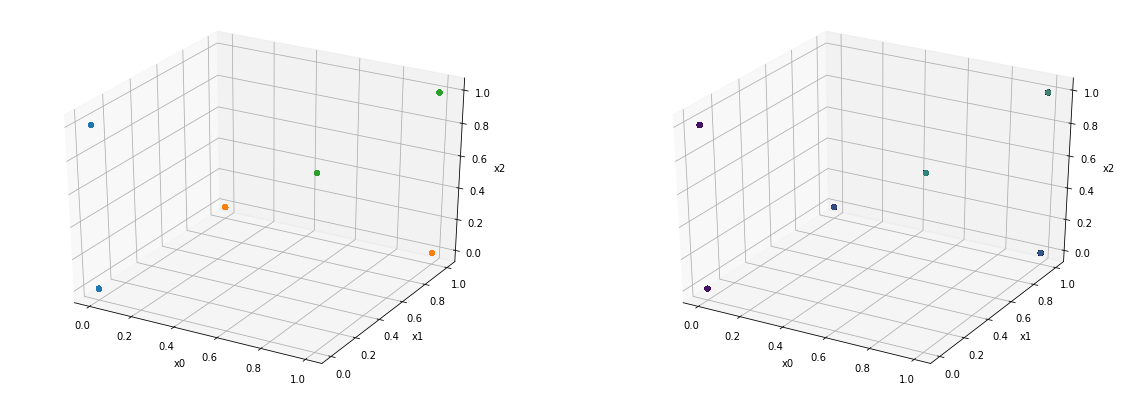

In [3]:
ds = Points3D()

In [4]:
(x_train, ye_train, y_train, e_train,
 x_val, ye_val, y_val, e_val,
 x_test, ye_test, y_test, e_test) = ds.get_train_val_test_from_splits(test_id=0, val_id=1)
 #train_df_orig, val_df_orig, test_df_orig) = ds.get_train_val_test_from_splits(test_id=0, val_id=1)

print('Testing on %d-----------------------------' % 1)
print(x_train.shape, x_val.shape)

Testing on 1-----------------------------
(5400, 3) (1800, 3)


In [5]:
# special for RSF
dt = np.dtype('bool,float')
y_train_surv = np.array([(bool(e), y) for e, y in zip(e_train, y_train)], dtype=dt)
y_val_surv = np.array([(bool(e), y) for e, y in zip(e_val, y_val)], dtype=dt)
y_test_surv = np.array([(bool(e), y) for e, y in zip(e_test, y_test)], dtype=dt)
print(y_train_surv.shape, y_val_surv.shape, y_test_surv.shape)

# train RSF
# rsf = RandomSurvivalForest(n_estimators=50,
#                            min_samples_split=5,
#                            min_samples_leaf=5,
#                            max_features="sqrt",
#                            oob_score=True,
#                            n_jobs=-1,
#                            random_state=20)
# rsf.fit(x_train, y_train_surv)
# pickle.dump(rsf, open('Points3D_rsf_model.mdl', 'wb'))

#rsf = pickle.load(open('Points3D_rsf_model.mdl', 'rb'))

cph = CoxPHSurvivalAnalysis(alpha=0).fit(x_train, y_train_surv)

(5400,) (1800,) (1800,)


In [6]:
cindex_train = cph.score(x_train, y_train_surv)
cindex_val = cph.score(x_val, y_val_surv)
cindex_test = cph.score(x_test, y_test_surv)

In [7]:
# cindex_train = rsf.score(x_train, y_train_surv)
# cindex_oob = rsf.oob_score_
# cindex_val = rsf.score(x_val, y_val_surv)
# cindex_val_events = rsf.score(x_val[e_val==1], y_val_surv[e_val==1])

print('Train cindex {:.2f}'.format(cindex_train*100))
print('Val cindex {:.2f}'.format(cindex_val*100))
print('Test cindex {:.2f}'.format(cindex_test*100))

Train cindex 82.32
Val cindex 83.16
Test cindex 81.67


In [8]:
cph_feature_importnce_df = pd.DataFrame(zip(ds.features_names, cph.coef_), columns=['Feature', 'Importance'])
cph_feature_importnce_df.set_index('Feature', inplace=True)

cph_feature_importnce_df['Color'] = cph_feature_importnce_df['Importance'].map(lambda x: 'C0' if x>=0 else 'C1')
cph_feature_importnce_df['Abs_Imp'] = cph_feature_importnce_df['Importance'].abs()

cph_feature_importnce_df.head()

,Importance,Color,Abs_Imp
Feature,,,
X0,-1.165332,C1,1.165332
X1,-0.565243,C1,0.565243
X2,-0.581594,C1,0.581594


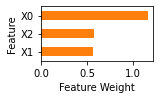

In [9]:
plt.figure(figsize=(2, 1))
cph_feature_importnce_df.sort_values('Abs_Imp')['Abs_Imp'].plot.barh(color=cph_feature_importnce_df.sort_values('Abs_Imp')['Color'])
plt.xlabel('Feature Weight')
plt.savefig('Results/Points3D_Cox/Points_cox_w.pdf', format='pdf', bbox_inches='tight')

In [10]:
surv_train = cph.predict_survival_function(x_train)
surv_train = np.array([s.y for s in surv_train])

surv_val = cph.predict_survival_function(x_val)
surv_val = np.array([s.y for s in surv_val])

surv_test = cph.predict_survival_function(x_test)
surv_test = np.array([s.y for s in surv_test])

event_times = cph.baseline_survival_.x

#Explanation
xte_data = (x_train, y_train, e_train,
            x_val, y_val, e_val,
            x_test, y_test, e_test)

survival_curves = (surv_train, surv_val, surv_test)

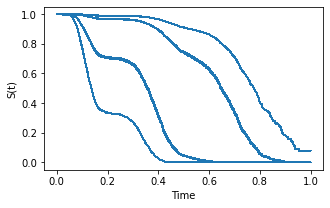

In [31]:
plt.figure(figsize=(5,3))
for s in surv_test:
    plt.step(event_times,s, alpha=0.01, c='C0')
plt.xlabel('Time')
plt.ylabel('S(t)')
plt.savefig('Results/Points3D_Cox/cph_survival_funcs.pdf', format='pdf', bbox_inches='tight')

shape: 5400


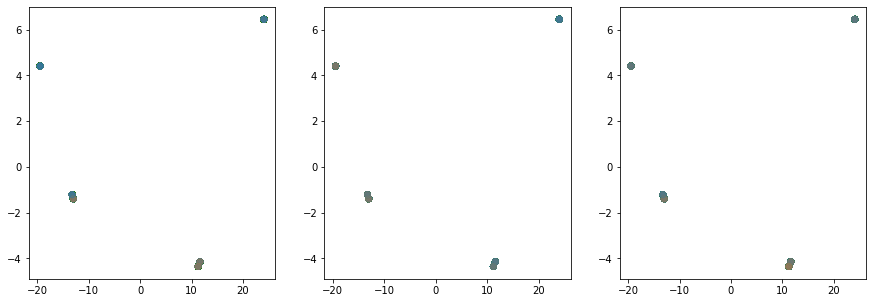

Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
Number of distinct clusters (6) found smaller than n_clusters (11). Possibly due to duplicate points in X.
Number of distinct clusters (6) found smaller than n_clusters (12). Possibly due to duplicate points in X.
Number of distinct clusters (6) found smaller than n_clusters (13). Possibly due to duplicate points in X.
Number of distinct clusters (6) found smaller than n_clusters (14). Possibly due to duplicate points in X.


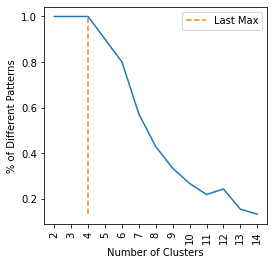

<Figure size 360x360 with 0 Axes>

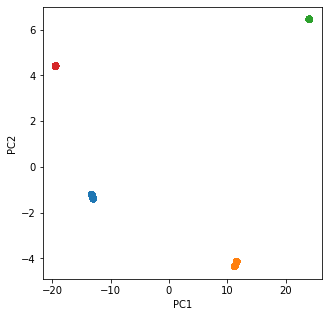

<Figure size 360x360 with 0 Axes>

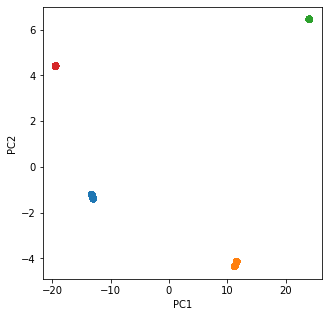

<Figure size 360x360 with 0 Axes>

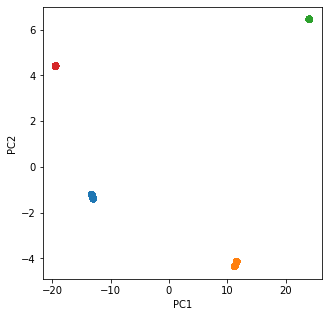

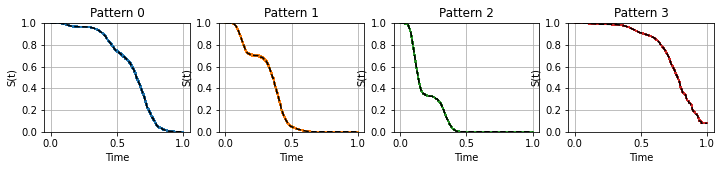

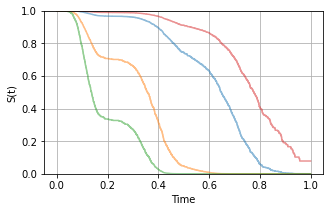

In [11]:
explainer = XSurvKMeansRF(prefix_name='Points3D_Cox', max_k=15, z_explained_variance_ratio_threshold=0.99, curves_diff_significance_level=0.05)
explainer.fit(xte_data=xte_data, survival_curves=survival_curves, event_times=event_times)#, pretrained_clustering_model="clustering_model_eve_9_20220223-152051.mdl", k=9)

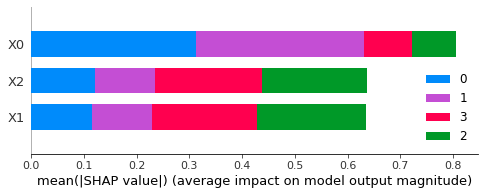

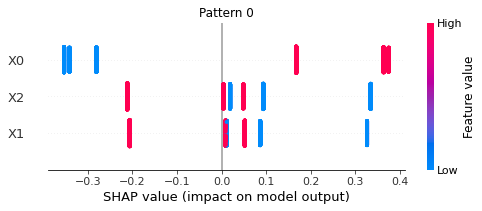

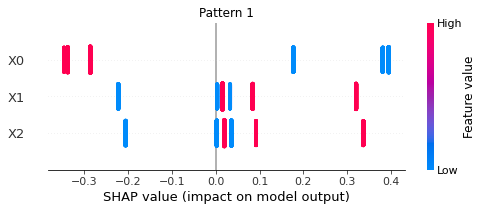

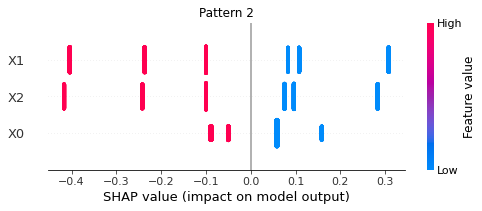

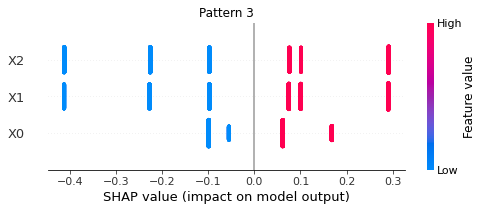

In [12]:
shap_values_train = explainer.explain(x=x_train, features_names_list=ds.features_names, suffex='train')

Text(0.5, 0, 'x2')

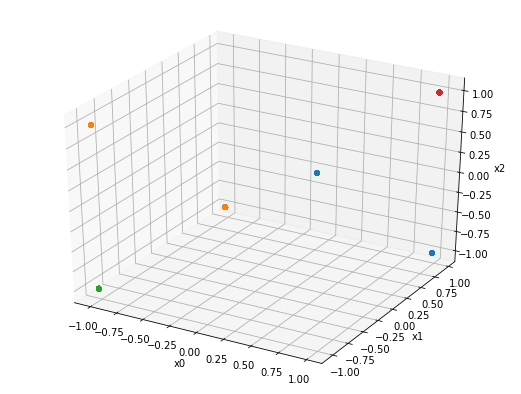

In [13]:
import matplotlib.pyplot as plt
def getc(c):
    return [f'C{i}' for i in c]

fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121, projection='3d')

ax.scatter(x_train[:, 0], x_train[:, 1], x_train[:, 2], c=getc(explainer.labels_train), alpha=0.2)
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')

In [14]:
rs = cph.predict(x_train)
h = np.exp(rs)

In [15]:
h.min()

0.10143808217097249

Text(0.5, 0, 'x2')

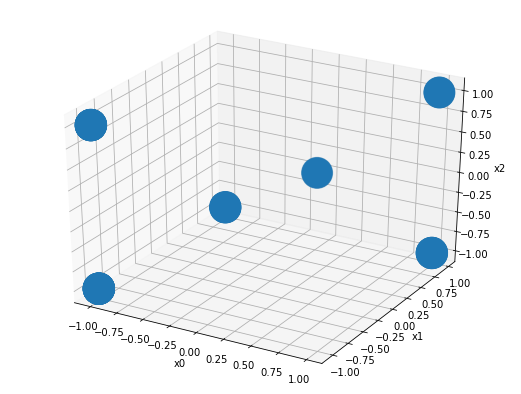

In [16]:
import matplotlib.pyplot as plt
def getc(c):
    return [f'C{i}' for i in c]

fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121, projection='3d')

ax.scatter(x_train[:, 0], x_train[:, 1], x_train[:, 2], s=(np.exp(-(y_train*10)))*1000, alpha=0.2)
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
#plt.colorbar()

Text(0.5, 0, 'x2')

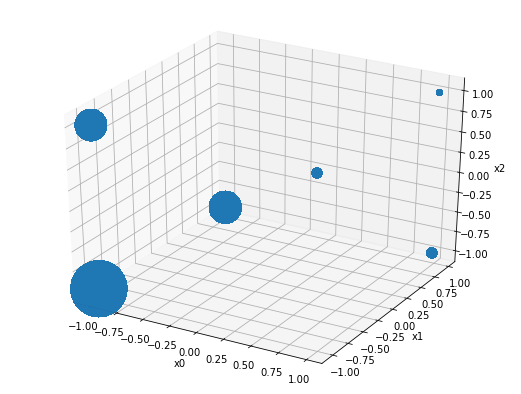

In [17]:
import matplotlib.pyplot as plt
def getc(c):
    return [f'C{i}' for i in c]

fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121, projection='3d')

ax.scatter(x_train[:, 0], x_train[:, 1], x_train[:, 2], s=h*300, alpha=0.2)
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
#plt.colorbar()

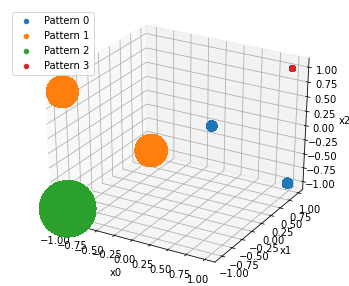

In [18]:
import matplotlib.pyplot as plt
def getc(c):
    return [f'C{i}' for i in c]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

for i in range(4):
    f = explainer.labels_train == i
    ax.scatter(x_train[f, 0], x_train[f, 1], x_train[f, 2], s=h[f]*300, c=f'C{i}', alpha=1, label=f'Pattern {i}')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
lgnd = ax.legend()
for handle in lgnd.legendHandles:
    handle.set_sizes([20])
#plt.colorbar()
plt.savefig('Results/Points3D_Cox/points_x_patterns_cph.pdf', format='pdf', bbox_inches='tight')

Text(0.5, 0, 'x2')

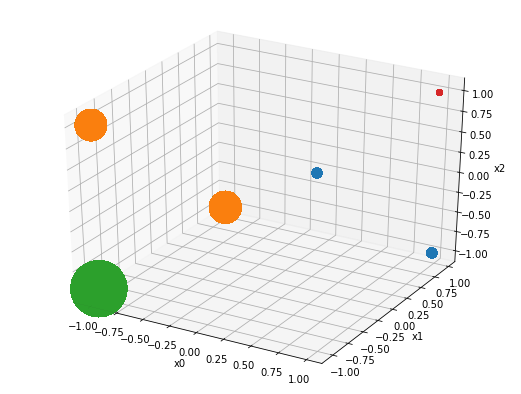

In [19]:
import matplotlib.pyplot as plt
def getc(c):
    return [f'C{i}' for i in c]

fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121, projection='3d')

ax.scatter(x_train[:, 0], x_train[:, 1], x_train[:, 2], s=h*300, c=getc(explainer.labels_train), alpha=0.2)
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
#plt.colorbar()

In [20]:
data = np.random.uniform(low=-1, high=1, size=(50000,3))
data.shape

(50000, 3)

In [21]:
data_rs = cph.predict(data)
data_h = np.exp(data_rs)

Text(0.5, 0, 'x2')

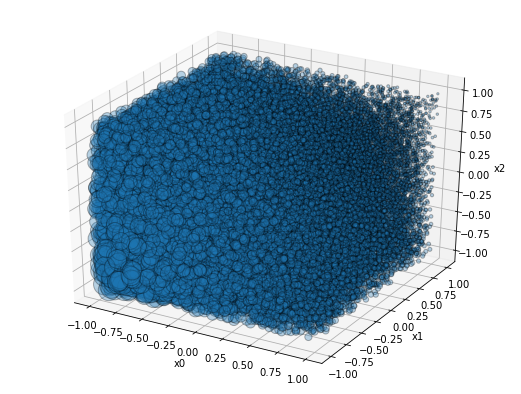

In [22]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2],s=data_h*50, alpha=0.3, edgecolors='black')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')

In [23]:
data_labels = explainer.classication_model.predict(data)

Text(0.5, 0, 'x2')

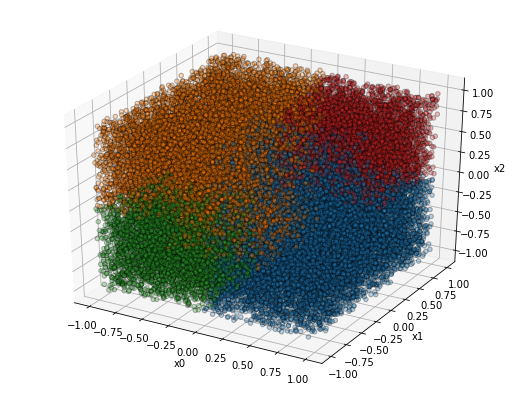

In [24]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=getc(data_labels), alpha=0.3, edgecolors='black')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')

Text(0.5, 0, 'x2')

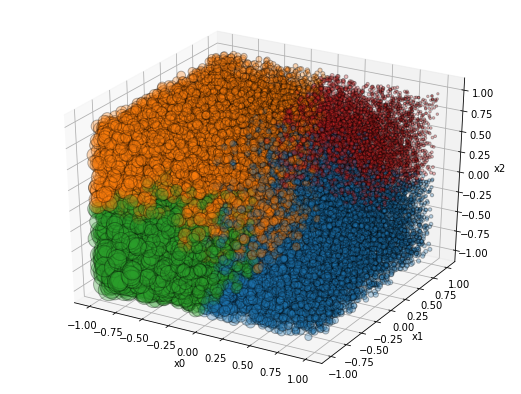

In [25]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=data_h*50, c=getc(data_labels), alpha=0.3, edgecolors='black')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')

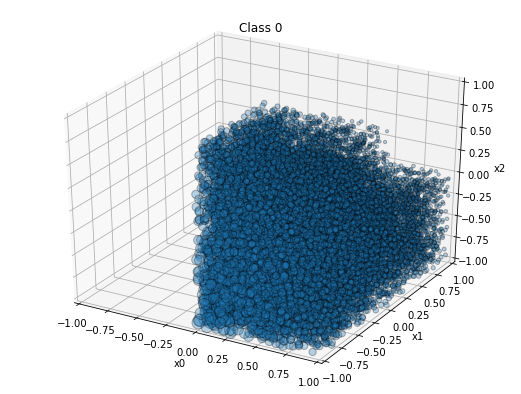

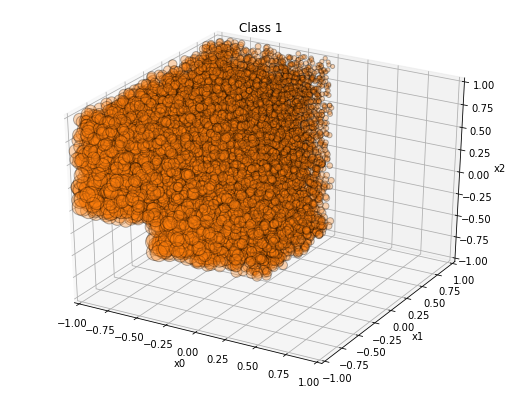

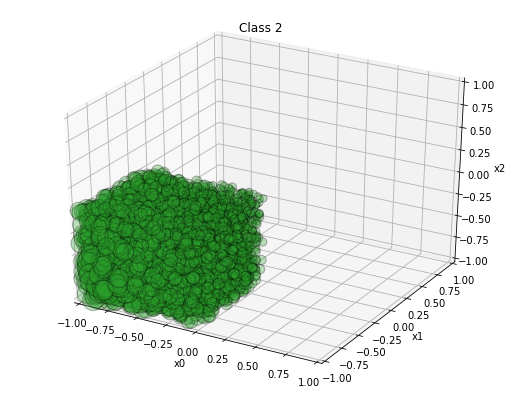

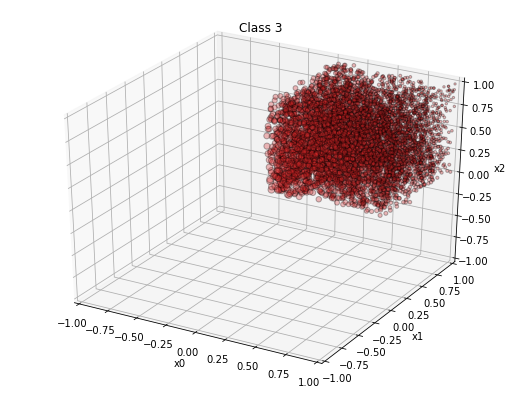

In [26]:
for i in range(len(set(explainer.labels_train))):
    f = (data_labels == i)
    fig = plt.figure(figsize=(20, 7))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(data[f, 0], data[f, 1], data[f, 2], s=data_h[f]*50, c=getc(data_labels[f]), alpha=0.3, edgecolors='black')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    ax.set_xlabel('x0')
    ax.set_ylabel('x1')
    ax.set_zlabel('x2')
    plt.title(f'Class {i}')


Text(0.5, 0, 'x2')

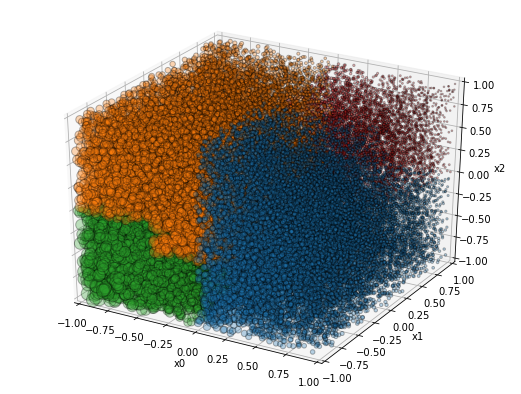

In [27]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121, projection='3d')
for i,s in [(0, '.'), (1, '^'), (2, 'o'), (3, 's')]:
    f = (data_labels == i)
    ax.scatter(data[f, 0], data[f, 1], data[f, 2], s=data_h[f]*20, c=getc(data_labels[f]), alpha=0.3, edgecolors='black')#, marker=s)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')


In [28]:
#shap_values_val = explainer.explain(x=x_val, features_names_list=ds.features_names, suffex='val')

In [29]:
#shap_values_test = explainer.explain(x=x_test, features_names_list=ds.features_names, suffex='test')